In [5]:
import PIL.Image
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [160]:
img_file = '/Users/cfuentes/Pictures/photo-cesar-2018.jpg'

In [161]:
img = PIL.Image.open(img_file)

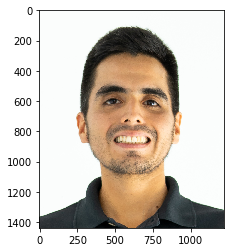

In [162]:
plt.imshow(img)

### GrabCut

In [79]:
# Load image
image_bgr = cv2.imread(img_file)
#image_bgr = cv2.resize(image_bgr, (256, 256))

In [80]:
# Convert to RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

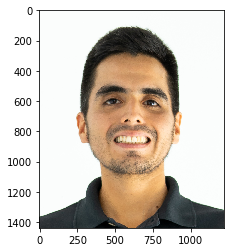

In [81]:
plt.imshow(image_rgb)

In [100]:
image_rgb.shape[-2::-1]

(1220, 1439)

In [104]:
# Rectange values: start x, start y, width, height
#rectangle = (0, 10, 256, 256)
rectangle = (0, 10) + image_rgb.shape[-2::-1]

In [105]:
rectangle

(0, 10, 1220, 1439)

In [106]:
# Create initial mask
mask = np.zeros(image_rgb.shape[:2], np.uint8)

# Create temporary arrays used by grabCut
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Run grabCut
cv2.grabCut(image_rgb, # Our image
            mask, # The Mask
            rectangle, # Our rectangle
            bgdModel, # Temporary array for background
            fgdModel, # Temporary array for background
            5, # Number of iterations
            cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle

# Create mask where sure and likely backgrounds set to 0, otherwise 1
mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

# Multiply image with new mask to subtract background
image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]

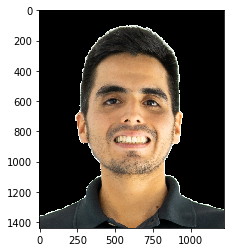

In [107]:
plt.imshow(image_rgb_nobg)

### Canny

In [144]:
#== Parameters =======================================================================
BLUR = 21
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 200
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (1.0,0.0,0.0) # In BGR format


#== Processing =======================================================================

#-- Read image -----------------------------------------------------------------------
img = cv2.imread(img_file)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

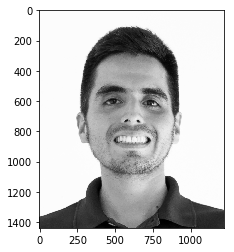

In [145]:
plt.imshow(gray, cmap='gray')

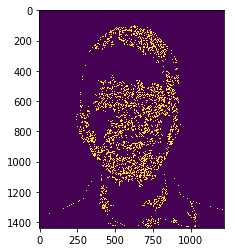

In [114]:
#-- Edge detection -------------------------------------------------------------------
edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
plt.imshow(edges)

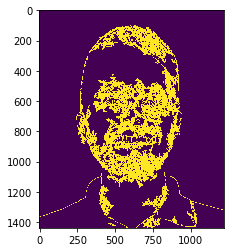

In [115]:
edges = cv2.dilate(edges, None)
plt.imshow(edges)

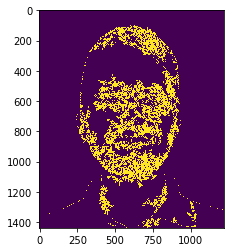

In [116]:
edges = cv2.erode(edges, None)
plt.imshow(edges)

In [118]:
#-- Find contours in edges, sort by area ---------------------------------------------
contour_info = []
# _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Previously, for a previous version of cv2, this line was: 
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Thanks to notes from commenters, I've updated the code but left this note
for c in contours:
    contour_info.append((
        c,
        cv2.isContourConvex(c),
        cv2.contourArea(c),
    ))
contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
max_contour = contour_info[0]

In [121]:
len(contour_info)

2386

In [127]:
max_contour[0].shape, max_contour[1:]

((9143, 1, 2), (False, 562738.5))

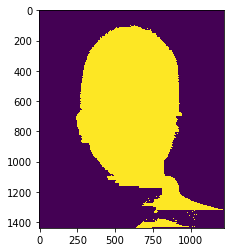

In [128]:
#-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
# Mask is black, polygon is white
mask = np.zeros(edges.shape)
cv2.fillConvexPoly(mask, max_contour[0], (255))

plt.imshow(mask)

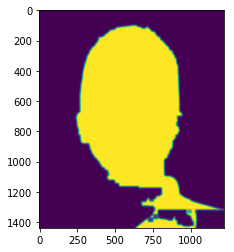

In [133]:
#-- Smooth mask, then blur it --------------------------------------------------------
mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

plt.imshow(mask)

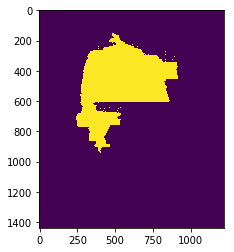

In [153]:
#-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
# Mask is black, polygon is white
mask2 = np.zeros(edges.shape)
cv2.fillConvexPoly(mask2, contour_info[1][0], (255))

plt.imshow(mask2)

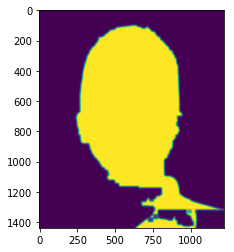

In [133]:
#-- Smooth mask, then blur it --------------------------------------------------------
mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

plt.imshow(mask)

In [140]:
mask_stack.max(), mask_stack.min(), img.max()

(255.00000000000014, 0.0, 255)

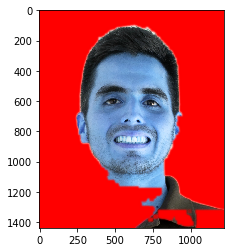

In [146]:
#-- Blend masked img into MASK_COLOR background --------------------------------------
mask_stack_f  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
img_f         = img.astype('float32') / 255.0                 #  for easy blending

masked_f = (mask_stack_f * img_f) + ((1-mask_stack_f) * MASK_COLOR) # Blend
masked = (masked_f * 255).astype('uint8')                     # Convert back to 8-bit 

plt.imshow(masked)    

### skimage Normalized Cut

In [7]:
from skimage import data, segmentation, color
from skimage.future import graph

In [70]:
img = PIL.Image.open(img_file)
img.thumbnail((256, 256))
img = np.array(img)
type(img), img.shape

(numpy.ndarray, (256, 217, 3))

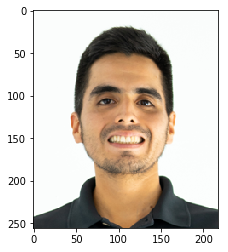

In [71]:
plt.imshow(img)

In [72]:
labels1 = segmentation.slic(img, n_segments=400, slic_zero=True) # compactness=30, )
out1 = color.label2rgb(labels1, img, kind='avg')

print(np.unique(labels1).shape)

(377,)


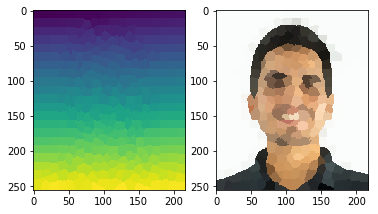

In [73]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(labels1)
ax[1].imshow(out1)

In [74]:
# just trying
segments_fz = segmentation.felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
out_fz = color.label2rgb(segments_fz, img, kind='avg')

print(np.unique(segments_fz).shape)

(87,)


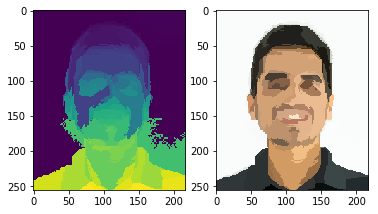

In [75]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(segments_fz)
ax[1].imshow(out_fz)

In [76]:
import time
t0 = time.time()
g = graph.rag_mean_color(img, labels1, mode='similarity')
t1 = time.time()
labels2 = graph.cut_normalized(labels1, g)
t2 = time.time()
out2 = color.label2rgb(labels2, img, kind='avg')
t3 = time.time()

print(f'Graph: {t1 - t0}, Cut: {t2 - t1}, labels: {t3 - t2} s')

Graph: 0.516686201095581, Cut: 0.5348191261291504, labels: 0.008238077163696289 s


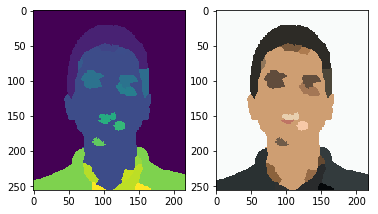

In [77]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(labels2)
ax[1].imshow(out2)

In [78]:
lu, lc = np.unique(labels2, return_counts=True)
label_counts = sorted(zip(lu, lc), key=lambda x: -x[1])
print(len(label_counts))
print('\n'.join('%d\t%d\t%f' % (l, c, c / (img.shape[0] * img.shape[1])) for l, c in label_counts))

22
0	28906	0.520341
88	14146	0.254644
36	3633	0.065398
304	2433	0.043797
303	2166	0.038990
338	632	0.011377
141	592	0.010657
133	420	0.007560
143	345	0.006210
335	319	0.005742
161	313	0.005634
77	252	0.004536
231	193	0.003474
344	189	0.003402
250	173	0.003114
376	155	0.002790
284	149	0.002682
89	133	0.002394
374	128	0.002304
318	113	0.002034
107	81	0.001458
237	81	0.001458


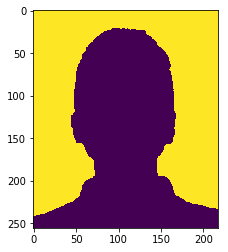

In [79]:
mask0 = labels2 == 0
plt.imshow(mask0)

In [80]:
masked = (img * (1 - mask0[:,:,None]))

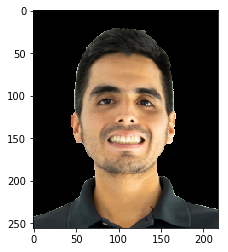

In [81]:
plt.imshow(masked)

In [108]:
img_file2 = '/Users/cfuentes/Pictures/running/sola2018_2.jpeg'

In [109]:
img = PIL.Image.open(img_file2)
img.thumbnail((256, 256))
img = np.array(img)
type(img), img.shape

(numpy.ndarray, (256, 186, 3))

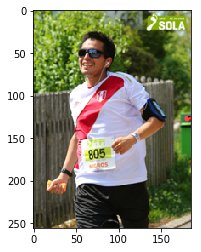

In [110]:
plt.imshow(img)

In [111]:
labels1 = segmentation.slic(img, n_segments=400, slic_zero=True) # compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

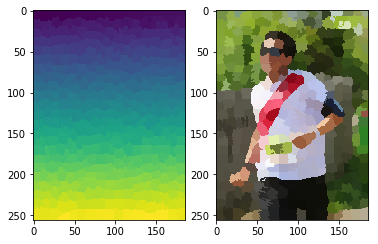

In [112]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(labels1)
ax[1].imshow(out1)

In [113]:
import time
t0 = time.time()
g = graph.rag_mean_color(img, labels1, mode='similarity')
t1 = time.time()
labels2 = graph.cut_normalized(labels1, g)
t2 = time.time()
out2 = color.label2rgb(labels2, img, kind='avg')
t3 = time.time()

print(f'Graph: {t1 - t0}, Cut: {t2 - t1}, labels: {t3 - t2} s')

Graph: 0.41576099395751953, Cut: 5.421074151992798, labels: 0.013218879699707031 s


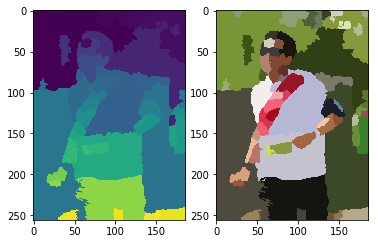

In [114]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(labels2)
ax[1].imshow(out2)

In [115]:
lu, lc = np.unique(labels2, return_counts=True)
label_counts = sorted(zip(lu, lc), key=lambda x: -x[1])
print(len(label_counts))
print('\n'.join('%d\t%d\t%f' % (l, c, c / (img.shape[0] * img.shape[1])) for l, c in label_counts))

61
153	7242	0.152092
0	6304	0.132392
149	5574	0.117061
41	4086	0.085811
321	3706	0.077831
238	3634	0.076319
119	3351	0.070376
14	1772	0.037214
135	798	0.016759
126	552	0.011593
210	549	0.011530
91	532	0.011173
7	518	0.010879
129	501	0.010522
51	462	0.009703
376	442	0.009283
171	398	0.008359
57	361	0.007581
240	352	0.007392
255	297	0.006237
306	275	0.005775
13	272	0.005712
175	267	0.005607
204	266	0.005586
259	247	0.005187
70	244	0.005124
10	241	0.005061
227	235	0.004935
87	232	0.004872
35	219	0.004599
195	213	0.004473
380	209	0.004389
11	187	0.003927
159	177	0.003717
254	168	0.003528
221	167	0.003507
196	166	0.003486
50	133	0.002793
377	132	0.002772
161	126	0.002646
115	124	0.002604
33	122	0.002562
66	120	0.002520
205	113	0.002373
118	111	0.002331
138	101	0.002121
264	101	0.002121
145	100	0.002100
12	99	0.002079
234	98	0.002058
325	97	0.002037
387	97	0.002037
191	96	0.002016
162	93	0.001953
218	90	0.001890
2	89	0.001869
16	80	0.001680
202	79	0.001659
130	72	0.001512
389	66	0.001386
181

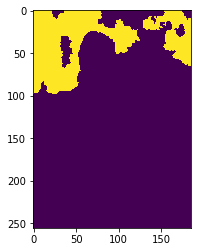

In [90]:
mask0 = np.isin(labels2, (148, 0, 142, 52, 14))
plt.imshow(mask0)

In [91]:
masked = (img * (1 - mask0[:,:,None]))

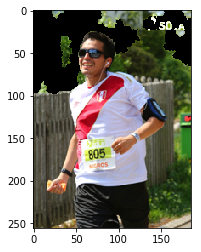

In [92]:
plt.imshow(masked)

### PyTorch FCN

In [116]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /Users/cfuentes/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:34<00:00, 5.20MB/s] 
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /Users/cfuentes/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:40<00:00, 5.44MB/s] 


In [135]:
img = PIL.Image.open(img_file2)

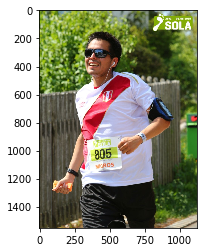

In [136]:
plt.imshow(img)

In [137]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 # T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [138]:
inp.shape

torch.Size([1, 3, 352, 256])

In [139]:
 # Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 352, 256])


In [140]:
import torch
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(352, 256)
[ 0 15]


In [141]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [144]:
def decode_segmap2(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    image_flat = image.ravel()
    rgb = label_colors[image_flat]
    return rgb.reshape(image.shape + (3,)).astype(np.uint8)

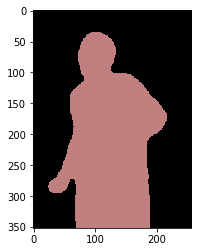

In [145]:
rgb = decode_segmap2(om)
plt.imshow(rgb)

In [147]:
np.all(decode_segmap(om) == decode_segmap2(om))

True

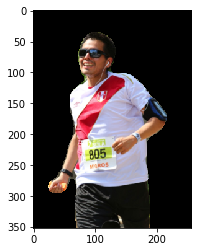

In [143]:
img_r = T.Resize(256)(img)
masked = img_r * ((om != 0)[:,:,None])
plt.imshow(masked)

In [152]:
def segment(net, path, show_orig=True, dev='cpu'):
  img = PIL.Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(256), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap2(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

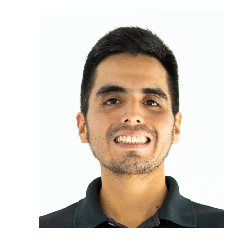

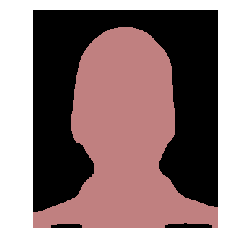

In [154]:
segment(fcn, img_file)

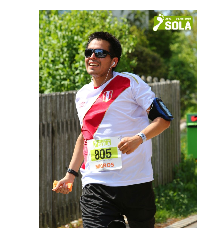

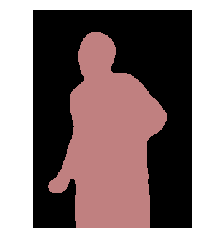

In [153]:
segment(fcn, img_file2)

In [155]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/cfuentes/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:45<00:00, 5.36MB/s] 


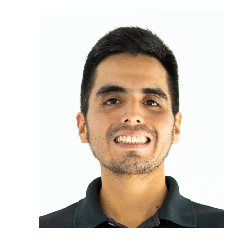

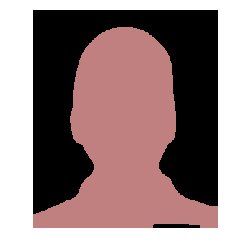

In [156]:
segment(dlab, img_file)

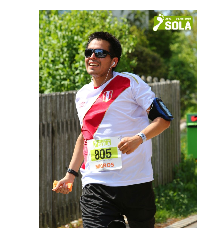

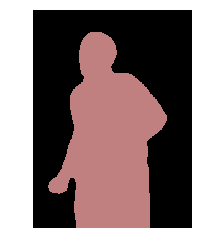

In [157]:
segment(dlab, img_file2)